# CS x476 - Fall 2021
# Project 3 : Scene Recognition with Deep Learning

## Brief
* Due: Monday, October 25, 2021, 11:59PM

* Hand-in: through Gradescope
* Required files:
  * `<your_gt_username>.zip`
  * `<your_gt_username>.pdf`

## Outline
In this project, we will use *convolutional neural nets* to classify images into different scenes.

Basic learning objectives of this project:
1. Construct the fundamental pipeline for performing deep learning using PyTorch;
2. Understand the concepts behind different layers, optimizers.
3. Experiment with different models and observe the performance.


## Compute Requirements

This project is doable without a GPU, but a GPU makes the training and testing portions of this project in Parts 4-6, and the Extra Credit much faster. To use GPU for these parts, you can try out Google Colab to run this notebook. Please read and follow the below instructions carefully.

## Colab Instructions
These are the steps we follow if you would like to use Colab:
1. Upload this notebook to Google Drive and open it in Colab.
2. Zip the project folder (cv_proj3_release) on your machine.
3. Now, we will upload the zip to Colab runtime environment. To do this, click on the `Files` icon on the left pane. This should show the Files that are present in the runtime.
4. Upload the zip folder to the runtime env by clicking on the `Upload` icon present in the top ribbon of this `Files` pane (the one with little upwards-pointing arrow). You should see the zip files in the  `Files` tab now.
5. Unzip the uploaded zip using ```!unzip -qq cv_proj3_release.zip -d ./``` (cell with this command is given below)
5. After unzipping, cd into the folder using ```%cd cv_proj3_release.zip```. (cell with this command is given below)
6. **Go to Edit selection tab, click on notebook settings and set accelerator to GPU.**
7. Colab should have most of the dependencies already installed. If you need to install any dependencies (when you encounter import error), you could add code blcks in Colab and enter ```!pip install <package_name>```. 
8. Remember, if you are using the free version of Colab, the runtime might only be valid for a limited amount of time if you make no changes. You will lose the uploaded files and runtime environment if the runtime is recycled by Colab. Refresh or run cells often if you need the runtime to be saved.
9. **Please complete the coding part first locally and test whether the code basically works before uploading to Colab. Editing .py on Colab runtime is rather inconvenient and doesnt save them locally. You should use Colab only as a platform with GPU to test your model.**

Tips: If you don't see changes in the Files tab, click on the file icon on the leftmost bar once more to refresh.

***Please note that we only intend for you to use Colab only to test your code in student_code.py. You must be sure to develop your student_code.py locally and make sure all the functions work as desired and THEN upload to Colab to achieve faster training and testing results. IF YOU ATTEMPT TO EDIT student_code.py IN COLAB AFTER UPLOADING IT INTO RUNTIME AND RUNTIME DISCONNECTS/EXPIRES, YOU WILL LOSE THE EDITS THAT YOU MADE TO YOUR student_code.py. Please only use Colab to test your student_code.py. If you need to make any edits to student code after uploading it to Colab, you will have to make the edits locally and follow the instructions above to re-upload the project into Colab Runtime.***

## Setup

In [ ]:
# To use on colab, uncomment the following lines
#!unzip -qq cv_proj3_release.zip -d ./
#%cd cv_proj3_release

In [6]:
use_colab_paths = False # switch to True if you're using colab

## Dataset
The dataset is in the ```data``` folder. It has two subfolders: ```train``` and ```test```. Go through any of the folder and you will find the folders with scene names like *bedroom*, *forest*, *office*. These are the 15 scenes that we want our model to predict given an image. You can look into folder for each scene to find multiple images. All this data is labelled data provided to you for training and testing your model. You can look at `dataset.png` present in root folder to get an idea of the dataset. 

**Let's start coding now!**

## Setup

In [7]:
import os
import torch
import matplotlib.pyplot as plt

from cv_proj3_code.trainer import Trainer
from cv_proj3_code.student_code import (get_optimizer, SimpleNet, SimpleNetDropout, MyAlexNet, 
ImageLoader, get_fundamental_transforms, get_data_augmentation_transforms)
from cv_proj3_code.utils import compute_mean_and_std, visualize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from cv_proj3_code.cv_proj3_unit_tests.test_base import verify
from cv_proj3_code.cv_proj3_unit_tests.test_image_loader import test_dataset_length, test_unique_vals, test_class_values, test_load_img_from_path
from cv_proj3_code.cv_proj3_unit_tests.test_data_transforms import test_fundamental_transforms
from cv_proj3_code.cv_proj3_unit_tests.test_dl_utils import test_predict_labels, test_compute_loss
from cv_proj3_code.cv_proj3_unit_tests.test_simple_net import test_simple_net
from cv_proj3_code.cv_proj3_unit_tests.test_simple_net_dropout import test_simple_net_dropout
from cv_proj3_code.cv_proj3_unit_tests.test_my_alexnet import test_my_alexnet
from cv_proj3_code.cv_proj3_unit_tests.test_checkpoints import test_simple_net_checkpoint

In [4]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU
print("GPU available:", is_cuda)

GPU available: False


In [9]:
data_base_path = '../data/' if not use_colab_paths else 'data/'
model_base_path = '../model_checkpoints/' if not use_colab_paths else 'model_checkpoints/'

In [10]:
print(os.listdir(data_base_path))
print(os.listdir(model_base_path))

# TODO: check that these outputs are as per expectation. It will save a lot of time in debugging issues.

['.DS_Store', 'test', 'train']
['simple_net', 'quantized_alexnet', 'simple_net_dropout', 'alexnet']


To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

## 1 Datasets
One crucial aspect of deep learning is to perform data preprocessing. In DL, we usually *normalize* the dataset and perform some *transformations* on them. The transformations can either help the inputs be compatible with the model (say our model only works on 500x500 images and we need all input to be cropped/scaled to this size) or help in data-augmentation to improve performance (more on this later).


### 1.1 Compute mean and standard deviation of the dataset
In any machine learning task it is a good practice to normalize the features to a fixed range. In this project we are going to "zero-center" and "normalize" the dataset so that each entry has zero mean and the overall standard deviation is 1. 

We have provided util function `compute_mean_and_std()` in `utils.py` to compute the **mean** and **standard deviation** of both training and validation data. Make sure to understand the logic behind them.


In [11]:
dataset_mean, dataset_std = compute_mean_and_std(data_base_path)

In [12]:
print('Dataset mean = {}, standard deviation = {}'.format(dataset_mean, dataset_std))

Dataset mean = [0.45547487], standard deviation = [0.25316328]


### 1.2 ImageLoader

Now let's create the **Datasets** object to be used later during training. Remember back in Hybrid Images Project, we have initialized such a class to load 5 images? Here the task is similar: we have to load each image as well as its classification ground-truth label. The essence is to retrieve the paths to all the images required, and be able to provide the **path** and the **class id** when given an index.

**TODO 1:** Go through the code of `ImageLoader` in `student_code.py`, run the following code cell to answer question in the report.

In [16]:
# Initialize a new image loader instance of the 'test' dataset
# For train dataset, use 'train' for split
input_size = (64, 64)
image_loader = ImageLoader(data_base_path, 
                           split='test',
                          )

In [17]:
# Length of the dataset, returned by the __len__() function in ImageLoader class
print("Length of dataset: ", len(image_loader))

Length of dataset:  1500


In [18]:
# Classes in the dataset, returned by get_classes() function in ImageLoader class
print("Classes: ", image_loader.get_classes())

Classes:  {'forest': 0, 'bedroom': 1, 'office': 2, 'highway': 3, 'coast': 4, 'insidecity': 5, 'tallbuilding': 6, 'industrial': 7, 'street': 8, 'livingroom': 9, 'suburb': 10, 'mountain': 11, 'kitchen': 12, 'opencountry': 13, 'store': 14}


Lets take a look at the data type of the image and label returned from the image_loader. Is this the data type we want? 

In [15]:
sample_image, sample_label = next(iter(image_loader))
print("data type of sample_image : {}".format(type(sample_image)))
print("sample label : {}".format(sample_label))

data type of sample_image : <class 'PIL.Image.Image'>
sample label : 0


**Please answer the questions related to Part 1 in your report after running through this section.**


### 1.3 Data transforms
In this section, we will construct some fundamental transforms to process images into torch tensors, which we can provide as input to our model.

1. Resize the input image to the desired shape;
2. Convert it to a tensor;
3. Normalize them based on the computed mean and standard deviation.

**TODO 2:** For this part, complete the function `get_fundamental_transforms()` in `student_code.py` 

In [19]:
print("Testing your fundamental data transforms: ", verify(test_fundamental_transforms))

Testing your fundamental data transforms:  "Correct"


Now, that you have implemented fundamental transform, lets pass these as tranforms and reinstantiate our image_loader

In [22]:
input_size = (64, 64)
image_loader = ImageLoader(data_base_path, 
                            split='test', 
                           transform=get_fundamental_transforms(input_size, dataset_mean, dataset_std)
                          )

In [23]:
# Create an iterator and get the 0th item, returned by __getitem__() function in ImageLoader class
sample_image, sample_label = next(iter(image_loader))
print('Input image shape = ', sample_image.shape)
print('Label index = ', sample_label)

Input image shape =  torch.Size([1, 64, 64])
Label index =  0


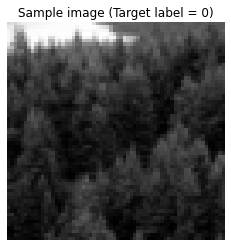

In [26]:
# Show the image of the 0th item in the dataset
fig, axs = plt.subplots()
axs.imshow(sample_image.squeeze().numpy(), cmap='gray')
axs.axis('off')
axs.set_title('Sample image (Target label = {})'.format(sample_label))
plt.show()


## 2 Model Architecture and Forward Pass

### 2.1 SimpleNet Model

The data is ready! Now we are preparing to move to the actual core of deep learning: the architecture. To get you started in this part, simply define a **2-layer** model in the class `SimpleNet` in `student_code.py`. Here by "2 layers" we mean **2 convolutional layers**, so you need to figure out the supporting utilities like ReLU, Max Pooling, and Fully Connected layers, and configure them with proper parameters to make the tensor flow.

You may refer the image *simplenet.jpg* in the base folder for a sample network architecture (it's the architecture TAs used in their implementation and is sufficient to get you pass Part 1).

**TODO 3**: Do the following in the class ```SimpleNet```:
- Initialize ```self.cnn_layers```
- Initialize ```self.fc_layers```
- Write the forward function

Leave the ```self.loss_criterion = None``` for now.

**NOTE** : More hints in doc string of SimpleNet. Also, the doc of pytorch [here](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#) can be helpful. Feel free to explore more on the internet.

In [29]:
print("Testing your SimpleNet architecture: ", verify(test_simple_net))

Testing your SimpleNet architecture:  "Correct"


### 2.2 Test the model structure

Let's see what out model's forward function produces for a sample input, and how it relates to classification. Pytorch's convolution and FC layers are initialized with random weights. So we should not expect any useful output without any training.

We will use a data-point from the dataloader we have already created and run the model on it.

In [52]:
# Initialize SimpleNet
simple_model = SimpleNet()

In [53]:
# Get the 0th sample
sample_image, sample_label = next(iter(image_loader))

In [54]:
sample_input = sample_image.unsqueeze(0)
print("input dimension: ", sample_input.shape)

input dimension:  torch.Size([1, 1, 64, 64])


In [55]:
# run the image through the model
sample_model_output = simple_model(sample_input).detach()

torch.Size([1, 1, 64, 64])
torch.Size([1, 54080])


In [56]:
print(sample_model_output)

tensor([[ 0.0757, -0.0358, -0.0265,  0.0288, -0.0046,  0.0410,  0.0711, -0.1041,
         -0.0040, -0.0742, -0.1032, -0.0071, -0.0169, -0.0947,  0.0376]])


In [57]:
print("output dimension: ", sample_model_output.shape)

output dimension:  torch.Size([1, 15])


We have a 15-dimensional tensor as output, but how does it relate to classification?

We first convert the this tensor into a probability distribution over 15 classes by applying the [Softmax](https://en.wikipedia.org/wiki/Softmax_function) operation.

In [58]:
sample_probability_values = torch.nn.functional.softmax(sample_model_output, dim=1)

In [60]:
print(sample_probability_values)
print(sample_probability_values.size())

tensor([[0.0728, 0.0652, 0.0658, 0.0695, 0.0672, 0.0704, 0.0725, 0.0609, 0.0673,
         0.0627, 0.0609, 0.0671, 0.0664, 0.0614, 0.0701]])
torch.Size([1, 15])


The prediction of the model will be the index where the probability distribution is the maximum. Convince yourself that the argmax-operation on *sample_model_output* is the same as the argmax-operation on *sample_probability_values*.

**TODO 4:** Complete the ```predict_labels()``` function in ```student_code.py```.

**Please provide the input and output dimensions of the SimpleNet in your report.**

## 3 Loss function

We have written a model which takes in a tensor for an image and produces a 15 dimensional output for it. We saw in the previous section on how the output relates to the prediction and probability distribution. But how do we quantify the performance of the model, and how do we use that quantification to form an objective function which we can minimize.

Ideally, we would want the probability function to have value 1 for the target *sample_label* and value 0 for the remaining class indices. To penalize the deviation between the desired probability distribution and the model-predicted distrtibution, we use the KL-divergence loss or the cross-entropy loss. Please refer to [this stackexchange post](https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation) for a good explanation and derivation.

**TODO 5:** Assign a loss function to ```self.loss_criterion``` in ```__init__()``` function of the class ```SimpleNet``` you created in *TODO 3* . 
Note that we have not done a softmax operation in the model's forward function and choose the [appropriate loss function](https://pytorch.org/docs/stable/nn.html#loss-functions).

**TODO 6:** Complete the ```compute_loss()``` function in ```student_code.py``` to use the model's loss criterion and compute the loss

In [66]:
simple_model = SimpleNet()

In [79]:
print(simple_model)

SimpleNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=54080, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


In [78]:
print("Testing your model prediction: ", verify(test_predict_labels))
print("Testing your loss values: ", verify(test_compute_loss))


Testing your model prediction:  "Correct"
Testing your loss values:  "Correct"


## 4 Optimizer

### 4.1 Manual gradient descent using Pytorch's autograd

Till now, we have defined the model, and designed a loss function which is a proxy for *good* classification. We now have to optimize the weights of the network so that the loss function is minimized.

Pytorch is a very useful library for deep learning because a lot of tensor operations and functions support the flow of gradients. This feature is called [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). This functionality lets us use gradient based optimization techniques like gradient descent without writing a lot of code.

Let us first understand how we can access the gradients.

### Define a model and a loss function
Suppose we have a simple objective function that looks like:
$$ L(w) =  w^2 - 10w + 25 $$

This is a convex problem, and we know that the loss $L$ is minimized for $w=5$, and we can obtain this in closed form by setting the derivative wrt $w$ to $0$ and solving.

But let us use gradient descent to obtain the solution in this case.

In [81]:
import torch
from torch import tensor

def quadratic_loss(w: tensor) -> tensor:
    assert w.shape==(1,)

    # loss function
    L = torch.pow(w, 2) - 10 * w + 25
    
    return L

Let's compute the loss at w = 0.

In [82]:
w = tensor([0.0], requires_grad=True)

loss = quadratic_loss(w)

print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.0000	Loss=25.0000


Now we can do a backward pass of the gradients to get the gradient of loss w.r.t w. Now we need to calculate the gradients with respect to the weights and biases using backprop. It will be very painful to do it manually, but thankfully, in PyTorch we've got it covered with autograd, which only needs a simple call of **.backward()** on our loss.

In [87]:
# perform backward pass on loss (we need to retain graph here otherwise Pytorch will throw it away)
loss.backward(retain_graph=True)

print(w.grad.data)

# explicitly zero the parameter gradients
w.grad.zero_()
pass

tensor([-10.])


Does this gradient match with the one you computed earlier?

With the gradients, we can update the weights and biases using gradient descent:
$$w_{k+1}=w_{k} - \alpha\frac{\partial L}{\partial w_k}$$
where $w$ is the parameter we are updating, $\alpha$ is the learning rate, and $\frac{\partial L}{\partial w_k}$ is the gradient at step $k$. You can learn more about gradient descent [here](https://en.wikipedia.org/wiki/Gradient_descent) and [here](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent)

In [88]:
# set learning rate
lr = .03

def gradientDescentStep(w: tensor, L: tensor, lr: float=1e-3) -> None:
    '''
    Take a step of the gradient descent
    '''
    
    # manually zero out the gradient
    w.grad.zero_()

    # perform backward on loss (we need to retain graph here otherwise Pytorch will throw it away)
    L.backward(retain_graph=True)
    
    with torch.no_grad():
        w -= lr * w.grad

Let's take one step of the gradient descent and check if the the loss value decreased

In [89]:
loss = quadratic_loss(w)

gradientDescentStep(w, loss, lr) 

In [90]:
loss = quadratic_loss(w)
print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.3000	Loss=22.0900


Looks like it's been optimized!

Now let's run a few more updates and see where we can get!

In [91]:
import time


start = time.time()
for i in range(200):
    loss = quadratic_loss(w)
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
    gradientDescentStep(w, loss, lr) 
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=7.2527
Iteration 20: w=3.5495	Loss=2.1040
Iteration 30: w=4.2187	Loss=0.6104
Iteration 40: w=4.5792	Loss=0.1771
Iteration 50: w=4.7733	Loss=0.0514
Iteration 60: w=4.8779	Loss=0.0149
Iteration 70: w=4.9342	Loss=0.0043
Iteration 80: w=4.9646	Loss=0.0013
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=-0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.069 seconds


Seems that it's doing a great job training our model! The loss now has decreased significantly to a pretty small value.

### 4.2 Optimization using Pytorch's gradient descent optimizer

Now let's see how we can simplify this using the `torch.optim` package from PyTorch. You can see that using optimizer from `torch.optim` package can achieve the same results with a lot less code from our side. Also, there are many features available over the vanilla gradient descent. Let's use the Stochastic Gradient Descent (SGD) optimizer available in Pytorch.

In [92]:
from torch.optim import SGD

# define parameters we want to optimize
w = tensor([0.0], requires_grad=True)

optimizer = SGD([w], lr=lr)

start = time.time()
for i in range(200):
    loss = quadratic_loss(w)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=8.2081
Iteration 20: w=3.5495	Loss=2.3812
Iteration 30: w=4.2187	Loss=0.6908
Iteration 40: w=4.5792	Loss=0.2004
Iteration 50: w=4.7733	Loss=0.0581
Iteration 60: w=4.8779	Loss=0.0169
Iteration 70: w=4.9342	Loss=0.0049
Iteration 80: w=4.9646	Loss=0.0014
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.063 seconds


### 4.3 Setting up the optimizer for SimpleNet

We will now set up a utility function to define an optimizer on the loss for a model.

**TODO 7:** complete the ```get_optimizer()``` function in ```student_code.py```. The helper function accepts three basic configurations as defined below. Any other configuration is optional. *SGD* optimizer type should be supported, anything else is optional.

We need to define parameters such as - the optimizer type we want to use ( sgd, adam, etc. ), learning rate, weight decay, etc.

Here, we have initialized them to *placeholder* values for now. You'll train the model with these values and it will be bad. Then you can come back here and tune the parameters. We will revisit this part again later to tune these inorder to improve our classification. 


In [96]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-1,
  "weight_decay": 1e-1
}

In [97]:
optimizer = get_optimizer(simple_model, optimizer_config)

In [98]:
assert(optimizer is not None)

**Please briefly explain how an optimizer works in the report after going through this section.**

## 5 Training SimpleNet

Great! We have completed all the components required to train the our model. Let's pass in the model architecture, optimizer, transforms for both the training and testing datasets into the trainer, and proceed to the next cell to train it. If you have implemented everything correctly, you should be seeing a decreasing loss value.

We will use the ``Trainer`` class from ```trainer.py``` file which contains all the essential functions for training, plotting the accuracies. Make sure to understand it. 

**Note** in this project, we will be using the test set as the validation set (i.e. using it to guide our decisions about models and hyperparameters while training. In actual practice, you would not interact with the test set until reporting the final results. Oftentimes, you would not *know* the test set much less interacting with it.

**Note** that your CPU should be sufficient to handle the training process for all networks in this project, and the following training cells will take less than 5 minutes; you may also want to decrease the value for `num_epochs` and quickly experiment with your parameters. The default value of **20** is good enough to get you around the threshold for this Part, and you are free to increase it a bit and adjust other parameters in this part.

In [99]:
# re-init the model so that the weights are all random
simple_model = SimpleNet()
optimizer = get_optimizer(simple_model, optimizer_config)
input_size = (64,64)
trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net'),
                  train_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [100]:
import time
simple_net_start = time.time()
trainer.train(num_epochs=20)
simple_net_end = time.time()
print("The training time taken for simple net is {:.9f}".format(simple_net_end-simple_net_start))

Epoch:0, Training Loss:2.7054, Validation Loss:2.7127
Epoch:1, Training Loss:14.5174, Validation Loss:17.0099
Epoch:2, Training Loss:46.7803, Validation Loss:56.6402
Epoch:3, Training Loss:24.4523, Validation Loss:28.7055


KeyboardInterrupt: 

Now let's have your model predict on some examples and see how well it performs qualitatively. You should try the following cell multiple times to understand whats happening.

In [ ]:
# visualize train split
print("Examples from train split:")
visualize(simple_model, 'train', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path)

In [ ]:
# visualize test split
print("Examples from test split:")
visualize(simple_model, 'test', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path)

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

In [ ]:
print('Testing simple net weights saved: ', verify(test_simple_net_checkpoint))

After you have finished the training process, now plot out the loss and accuracy history. You can also check out the final accuracy for both training and validation data. Copy the accuracy plots and values onto the report, and answer the questions there. 

**TODO 8:** Obtain a **45%** validation accuracy to receive full credits for Part 1. You can go back to **Section 4.3** where we initialized the parameters for the optimizer. These are crucial to increase the performance of the model. So, tune your paramters for optimization using the following tips:

**Tips**:
1. If the loss decreases very slowly, try increasing the value of the lr (learning rate).
2. Initially keep the value of weight decay (L2-regulization) very low.
3. Try to first adjust lr in multiples of 3 initially. When you are close to reasonable performance, do a more granular adjustment.
4. If you want to increase the validation accuracy by a little bit, try increasing the weight_decay to prevent overfitting. Do not use tricks from subsequent sections just yet.

If you still need to tweak the model architecture, you are free to do so. But remember complex models will require more time to train, and TAs could achieve ~50% accuracy with the described model.

Make note of the hyperparameters that you finally arrived at. You will be asked to present them in the report.

## 6 Pretrained AlexNet
You can see that with our basic 2-layer SimpleNet, we were able to classify the images. However, we are not satisfied with its performance yet. We could add other techniques like Dropout which we defer to Extra Credit. 

We are going to take a different approach at the task now. Our model, in the end, is still a 2-layer SimpleNet and it might be capable of capturing some features, but it could be improved a lot if we go **deeper**. In this part, we are going to see the power of a famous model: AlexNet.

### 6.1 Data Augmentation with Jitter, Random Flip, and Normalization

Before diving into using Alexnet, we could do something to increase the amount of data samples we have. Since, having more data is always better.

One common and simple technique to achieve it is to **augment** it. Firstly, let's "jitter" it; secondly, we will use the fact that when you *mirror* an image of a kitchen, you can tell that the mirrored image is still a kitchen. 

**TODO 9:** finish the `get_data_augmentation_transforms()` function in `student_code.py`: you should first copy over the transforms you used in the existing fundamental transform implementation into this function, and then insert a couple of other transforms which help you do the above adjustment. This is because, we can pass only one augmentation function at a time to the trainer.

You are free to experiment with different kinds of augmentation techniques by adding new techniques or replacing existing techniques

In [ ]:
augmentation_transforms = get_data_augmentation_transforms((64, 64), dataset_mean, dataset_std )

In [ ]:
assert(len(augmentation_transforms.transforms) > 0)

### 6.2 Building AlexNet
PyTorch has provided us with pre-trained models like AlexNet, so what you want to do is to load the model first, and then adjust some of the layers such that it fits with our own dataset, instead of outputing scores to 1000 classes from the original AlexNet model.

There are many reasons for using pre-trained weights instead of training AlexNet from scratch:
1. We have a really small dataset ( even after augmenting ). Alexnet has millions of parameters and will definitely overfit. The pre-trained alexnet will have access to millions of training images.
2. We save a lot of computation.

**TODO 10:** Modify class `MyAlexNet` in `student_code.py`, for the below cell to work. Copy the network architecture and weights of all but the last fc layers from the pretrained network.(Think why all but last fc !)

After you have defined the correct architecture of the model, make some tweaks to the existing layers: **freeze** the **convolutional** layers and first 2 **linear** layers so we don't update the weights of them. More instructions are in the docstring.

Note that you are allowed to add more layers/unfreeze more layers if you see fit.

**NOTE** : It will be beneficial to look at the schematic of the AlexNet before modifying the layers. Understand what layers to freeze and their indices. Use the below cell to view the network before and after your modifications. Of course, you've to load the pre-trained model in `MyAlexNet` for the below cell to work.


In [110]:
my_alexnet = MyAlexNet()
print(my_alexnet)

MyAlexNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.

In [111]:
print("Testing your AlexNet architecture: ", verify(test_my_alexnet))

Testing your AlexNet architecture:  "Correct"


### 6.3 Training AlexNet
We will now train the `AlexNet`.

As done before, we initialize parameters for optimizer for AlexNet which you need to tune later to improve the performance.

In [112]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-1,
  "weight_decay": 1e-1
}

In [114]:
my_alexnet = MyAlexNet()
optimizer = get_optimizer(my_alexnet, optimizer_config)
input_size = (224, 224)

trainer = Trainer(data_dir=data_base_path, 
                  model = my_alexnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following training cell will take roughly 20 minutes or slightly more using CPU (but possibly under 5 minute using GPU depending on the batch size; the TAs got it within 3 minutes on colab).

In [115]:
trainer.train(num_epochs=5)

Epoch:0, Training Loss:2.7875, Validation Loss:2.8085


KeyboardInterrupt: 

Now let's have your model predict on some examples and see how well it performs qualitatively.

In [ ]:
# # visualize train split
print("Examples from train split:")
visualize(my_alexnet, 'train', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

In [ ]:
# # visualize test split
print("Examples from test split:")
visualize(my_alexnet, 'test', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

**TODO 11**: Similar to what we've done in the SimpleNet section, you are required to pass a threshold of **85%** for this part. For that, tune the hyperparameters. 

Copy the plots and values onto the report, present the final hyperparameters, and answer questions in the report accordingly.

## Extra Credits : 
***This part is optional for undergraduate students (4476), but required for graduate students (6476)***

## Extra Credit 1: Dropout

### Overfitting
We have obtained a 45% accuracy on the validation data with a SimpleNet; If you observe, it has good training accuracy (more than 90%, if you have implemented everything correctly) but not so great validation accuracy.

Our final accuracies for training and validation data differ a lot from each other, which indicates that the model we defined **fits too well with the training data, but is unable to generalize well on data it has not trained on**: this is often regarded as **overfitting** where the models fits the training data a little too well. We have some techniques to tackle with it: adjusting both data and model.

In **Section 6.1** we have seen how to adjust the data by using data augmentation. Now we will see how to adjust the model itself.

"Dropout" is a technique commonly used to regularize the network. It randomly turns off the connection between neurons inside the network and prevent the network from relying too much on a specific neuron. 

**TODO EC1.1:** finish the class `SimpleNetDropout` in `student_code.py`. It should be same as your previous SimpleNet model, except the dropout layer.

In [ ]:
print("Testing your SimpleNetDropout architecture: ", verify(test_simple_net_dropout))

In [ ]:
simple_model_dropout = SimpleNetDropout()
print(simple_model_dropout)

Similar to the previous parts, **initialize the following cell with proper values for learning rate and weight decay** for SimpleNetDropout

In [ ]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-1,
  "weight_decay": 1e-1
}

In [ ]:
simple_model_dropout = SimpleNetDropout()
optimizer = get_optimizer(simple_model_dropout, optimizer_config)
input_size = (64,64)
trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model_dropout,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net_dropout'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following cell will take longer than that of SimpleNet, as now we have more data (and more variability), and the model is slightly more complicated than before as well; however, it should finish within 10~15 minutes anyway, and the default `num_epochs` of **30** is also good enough as a starting point for you to pass this part.

In [ ]:
trainer.train(num_epochs=30)

Now let's have your model predict on some examples and see how well it performs qualitatively.

In [ ]:
# # visualize train split
print("Examples from train split:")
visualize(simple_model_dropout, 'train', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

In [ ]:
# # visualize test split
print("Examples from test split:")
visualize(simple_model_dropout, 'test', get_fundamental_transforms(input_size, dataset_mean, dataset_std), data_base_path=data_base_path)

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Similar to the previous part, now plot out the loss and accuracy history. Also copy the plots onto the report, and answer the questions accordingly.

**TODO EC1.2:** Achieve **52%** validation accuracy for full credits for this part. Tune hyperparameters.

Compare the training and valdiation accuracies you've achieved with the SimpleNet without any data augmentation and Dropout.
Copy the plots and values onto the report, present the final hyperparameters, and answer questions in the report accordingly.

## Extra Credit 2: Model Space/Compute improvement

We have created the AlexNet model which performs really well. But, can we deploy on a robot which does not have access to powerful GPUs and memory ? What if we want to make the model simpler and faster for inference. One option will be to use SimpleNet or a variant of it. But that has very low accuracy compared to AlexNet.

Can we utilize the AlexNet model which we have learnt and improve the memory/compute usage? This is an active research area with [several possible options](https://arxiv.org/pdf/1710.09282.pdf).

In this part, we will try quantizing our filter weights from 32-bit floating point to 8-bit integer. As you can guess, all the weights in the layers (in convolution and fully connected layers) will have a 75% reduction from this simple switch.

What about compute time? The first benefit is directly from lower memory foot-print. We can transfer more weights in the fixed memory bandwith and the cache can hold more weights too. Some CPU architectures might have INT8 computation units which can offer more speedup.

We might lose some accuracy when we sacrifice precision. Doing the fp32->int8 conversion directly is a bad choice. 
Suppose an activation is in a small range of $[0.1, 0.2]$. We cannot just round the weights as the activation might be the same for all the inputs. Hence we need to quantize based on the statistics of the activations.

This is a very brief introduction, and we expect you to read material online to complete this section.
[Pytorch's Introduction to Quantization](https://pytorch.org/blog/introduction-to-quantization-on-pytorch/) is a good starting point. We used the post-training static quantization scheme and got good performance. You are free to use any quantization scheme as long as it falls within one of the buckets of the rubric. **Please use the quantization modules provided by Pytorch as described in Pytorch's Introduction to Quantization.**

**TODO EC2.1**: Write the `forward` function in class `MyAlexNetQuantized`. Do remember that the input and the output of the function will not be quantized and you need to pass them through a layer for quantization/dequantization.


**TODO EC2.2**: Write the `quantize_model` function in `student_code.py`.

**Grading**: There are no unit tests for this portion. You will be required to write your idea, paste code snippets, and results in the report. The rubric for this section is a bit complicated and it is recommended to review it.

Please note that not all possible buckets may be possible to achieve using simple post-training static quantization scheme. You can obtain a decent performance here and come back later if you are inclined. Make sure you understand what you are doing as points will be alloted for that.

In [ ]:
from cv_proj3_code.student_code import quantize_model

In [ ]:
original_model = MyAlexNet().to('cpu')

In [ ]:
input_size = (224, 224)
alexnet_trainer = Trainer(data_dir=data_base_path, 
                  model = original_model,
                  optimizer = get_optimizer(original_model, optimizer_config),
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = True,
                  cuda = False
                 )

In [ ]:
image_loader = ImageLoader(data_base_path, 
                           split='train', 
                           transform=get_fundamental_transforms(input_size, dataset_mean, dataset_std)
                          )

In [ ]:
quantized_alexnet = quantize_model(original_model, image_loader)

In [ ]:
quantized_alexnet_trainer = Trainer(data_dir=data_base_path, 
                  model = quantized_alexnet,
                  optimizer = get_optimizer(original_model, optimizer_config),
                  model_dir = os.path.join(model_base_path, 'quantized_alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = False
                 )

quantized_alexnet_trainer.save_model()

### Size comparison

In [ ]:
quantized_alexnet_size = os.path.getsize(os.path.join(model_base_path, 'quantized_alexnet', 'checkpoint.pt'))/1e6
alexnet_size = os.path.getsize(os.path.join(model_base_path, 'alexnet', 'checkpoint.pt'))/1e6

In [ ]:
print('Original Alexnet Size: {:.2f}'.format(alexnet_size))
print('Quantized Alexnet Size: {:.2f}'.format(quantized_alexnet_size))
print('Percentage reduction: {:.2f}%'.format(100-100*quantized_alexnet_size/alexnet_size))

Now let's have your model predict on some examples and see how well it performs qualitatively.

### Processing Time comparison

In [ ]:
import time

def time_forward_pass(model: torch.nn.Module, input_tensor: torch.tensor) -> float:
    model.eval()
    start = time.time()
    for _ in range(300):
        model(input_tensor)
    end = time.time()
    
    return (end-start)/300

In [ ]:
sample_input, _ = next(iter(image_loader))
sample_input = sample_input.unsqueeze(0)

In [ ]:
quantized_alexnet_time = time_forward_pass(quantized_alexnet, sample_input)

In [ ]:
alexnet_time = time_forward_pass(original_model, sample_input)

In [ ]:
print('Original Alexnet Time: {:.2f}'.format(alexnet_time))
print('Quantized Alexnet Time: {:.2f}'.format(quantized_alexnet_time))
print('Percentage reduction: {:.2f}%'.format(100-100*quantized_alexnet_time/alexnet_time))

### Accuracy comparison

In [ ]:
_, alexnet_accuracy = alexnet_trainer.evaluate()
_, quantized_alexnet_accuracy = quantized_alexnet_trainer.evaluate()

In [ ]:
print('Original Alexnet Accuracy: {:.2f}'.format(alexnet_accuracy))
print('Quantized Alexnet Accuracy: {:.2f}'.format(quantized_alexnet_accuracy))
print('Percentage reduction: {:.2f}%'.format(100-100*quantized_alexnet_accuracy/alexnet_accuracy))

## Code testing
We have provided a set of tests for you to evaluate your implementation. We have included tests inside ```proj3.ipynb``` so you can check your progress as you implement each section. At the end, you should call the tests from the terminal using the command ```pytest cv_proj3_code/cv_proj3_unit_tests/```

## Submission

This is very important as you will lose 5 points for every time you do not follow the instructions.

Don't install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Don't use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using ```python zip_submission.py --gt_username <your_gt_username>``` (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

## TODO Checklist

### Required For All
* **TODO 1** : Understand the class ```ImageLoader``` and answer questions in report.
* **TODO 2** : complete the function ```get_fundamental_transforms()```
* **TODO 3** : complete the class ```SimpleNet```
* **TODO 4** : complete the function ```predict_labels()```
* **TODO 5** : Assign appropriate loss function to  ```self.loss_criterion``` in ```SimpleNet```
* **TODO 6** : complete the function ```compute_loss()```
* **TODO 7** : complete the function ```get_optimizer()```
* **TODO 8** : tune the hyperparameters for training ```SimpleNet``` to get validation accuracy of **>45%**
* **TODO 9** : complete the function ```get_data_augmentation_transforms()```
* **TODO 10** : Modify the class ```MyAlexNet```
* **TODO 11** : tune the hyperparameters for training ```MyAlexNet``` to get validation accuracy of **>85%**

### Extra Credit
* **TODO EC1.1** : finish the class `SimpleNetDropout` 
* **TODO EC1.2** : tune the hyperparameters for training `SimpleNetDropout` to get validation accuracy of **>52%**
* **TODO EC2.1** : Write the ```forward``` function in class ```MyAlexNetQuantized```
* **TODO EC2.2** : Write the ```quantize_model``` function in ```student_code.py```.



## Rubric
The distribution of points for code and report are mentioned in gradescope and report files.

**Rubric for EC2:**
- 3 points for describing the strategy and explaining the main ideas in the report.
- 3 If you achieve >50% reduction in size, >10% reduction in time, and <5% reduction in accuracy. That's a resonable output if you're using the quantization module of Pytorch properly.

## Credit

Assignment developed by Sarath Mutnuru and Lixing Liu based on a the original assignment by Ayush Baid, Haoxin Ma, Jing Wu, Cusuh Ham, Jonathan Balloch, Shenhao Jiang, Frank Dellaert, and James Hays.